In [1]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
import time
from  scipy.io import loadmat as loadmat
from google.colab import drive

In [2]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Mounted at /content/drive


Useful function for the plot

In [3]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1])
    else:
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = 'o'
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust+1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
        else:
            plt.scatter(x,y,50,col,marker=smb,edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)

Function that computes the residual between points and a line

In [4]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])


Functions to add outlier to the dataset

In [5]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax-xmin
    wy = ymax -ymin
    dx = k*wx
    dy = k*wy

    Y = np.hstack((X,np.vstack((xmax-xmin+2*dx * np.random.uniform(size=(1, nOutliers)) + xmin-dx,
                             ymax-ymin+2*dy * np.random.uniform(size=(1, nOutliers)) + ymin-dy))
                ))
    return Y



Ransac
------
Use the implementation from the last lecture

In [6]:
def fit_line_dlt(P):

  P = P.T # P is the matrix of points
  A = P # A now has num rows equal to cardmss, and num cols=2
  # design matrix
  A = np.hstack((A,np.ones((A.shape[0],1)))) #we want to add a column of ones (homogeneous coordinats)

  # SVD
  _, _, V = np.linalg.svd(A, full_matrices=False)
  V = V.T # since SVD gives V.T and not V
  theta = V[:,-1] # takes last column from V

  residuals = A @ theta   # finds the distance between the model and the points
  residual_error = np.sum(residuals**2)

  return theta, residuals, residual_error

In [7]:
def simpleRANSAC(X, eps, cardmss = 2):
  E_star = 0 # num points is that are closer then eps to the line
  n = X.shape[1] # num points available



  A = X.T # A now has num rows equal to cardmss, and num cols=2
  # design matrix
  A = np.hstack((A,np.ones((A.shape[0],1)))) #we want to add a column of ones


  e = 0.5 # inlier fraction
  p = 0.99 # prob that all MSS have at least one outlier (we take 1-p)
  k_max =  min( int(abs( (np.log(1-p) / np.log((1-(1-e)**cardmss))))) , 10)
  k = 0
  while k < k_max:
    idx = np.random.randint(0, n - 1, size=cardmss) # take cardmss random points
    mss = X[:, idx] # each col of X is a new point
    theta, _, _ = fit_line_dlt(mss)
    r = np.abs(A@theta) # we find abs distances of all points

    I = np.where(np.abs(r) <= eps)[0] # check where distance to line is less than eps
    E = len(I) # num inliers

    if E > E_star: #if more inliers than best model we updata best model
      theta_star = theta
      I_star = I
      E_star = E

    k = k + 1

  return theta_star, I_star

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


In [8]:
epsi = 0.06

#temp = loadmat(f'{rootfolder}/data/star5.mat')
temp = loadmat(f'{rootfolder}/data/stair4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 4           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.vstack( (G, np.zeros((nOut,1))) )


<ipython-input-3-afb5a87e94f6>:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
<ipython-input-3-afb5a87e94f6>:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


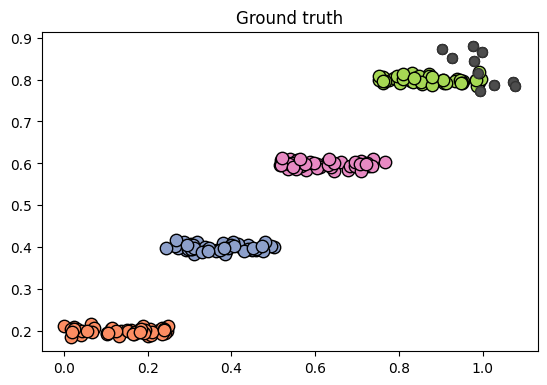

In [9]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [10]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    Model, Inliers = simpleRANSAC(Y, epsi)

    # Fit new model using all the inlier points to get a better model
    mss = Y[:, Inliers]
    Model, _, _ = fit_line_dlt(mss)

    if (len(Inliers) < E_min): # stop the loop if the best line is too bad
        break
    else:
        currentInliers.append(Inliers)
        currentModel.append(Model)

        # remove current inliers
        Y = np.delete(Y, Inliers, axis=1)

    # update iterations
    cnt = cnt + 1


Show the iteration of Sequential Ransac

(2, 210)


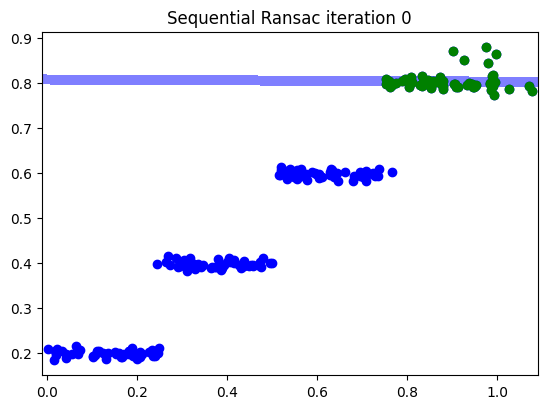

(2, 150)


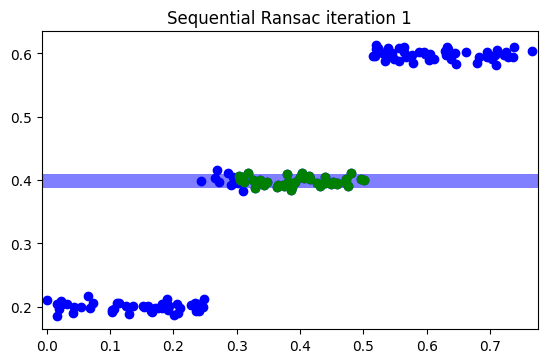

(2, 111)


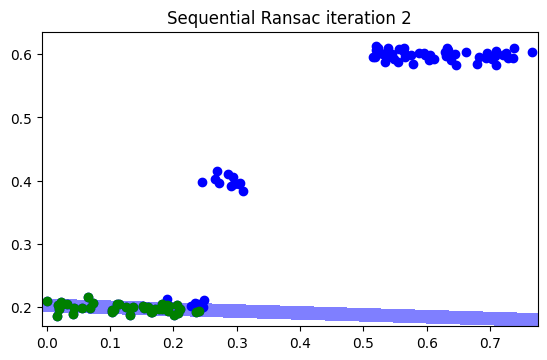

(2, 70)


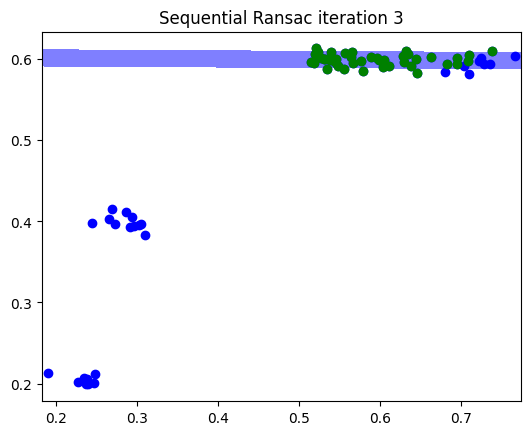

In [11]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):

    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], bw, col)

    print(Y.shape)
    # plot inliers for this model
    plt.scatter(Y[0, :], Y[1, :], c='blue')
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], c='green')

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y,currentInliers[i], axis=1)

    plt.title(f'Sequential Ransac iteration {i:d}')

    plt.show()

MultiModel fitting on circle
----------------------------


In [22]:
epsi = 0.02

temp = loadmat(f'{rootfolder}/data/circle5.mat')
#temp = loadmat(f'{rootfolder}/data/circle4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 3          # minimum number of points required to fit a model
#cardmss = 20          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.vstack( (G, np.zeros((nOut,1))) )

<ipython-input-3-afb5a87e94f6>:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
<ipython-input-3-afb5a87e94f6>:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


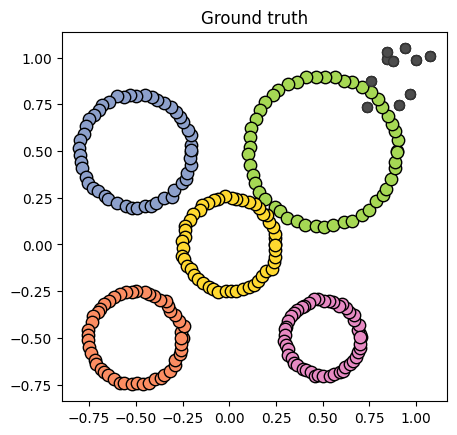

In [23]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

In [24]:
#functions for polar coordinats
import math

def polar_coord(points):
    angles = np.arctan2(points[1, :], points[0, :])
    distances = np.linalg.norm(points, axis=0)
    return angles, distances

def polar_to_cartesian(theta, r):
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    return (x, y)

In [25]:
def fit_circle_dlt_first(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    point_coordinates = np.column_stack((x - x_mean,y - y_mean)).T

    # SVD
    _, _, V = np.linalg.svd(point_coordinates, full_matrices=False)
    V = V.T

    # Extract the right singular vector corresponding to the smallest singular value
    circle_params = V[:, -1]

    # calculate the centers and the radius (equations form internet, can also be derived easily)
    xc = -circle_params[0]/2 + x_mean
    yc = -circle_params[1]/2 + y_mean
    r = np.sqrt(((-circle_params[0]/2 + x_mean)**2) + ((-circle_params[1]/2 + y_mean)**2) + np.abs(circle_params[2]))

    return xc, yc, r

In [26]:
# code tries using polar coordinates
def fit_circle_dlt_second(P):

    estimated_center = np.mean(P, axis=1)
    ang, d = polar_coord(P - estimated_center.reshape(-1, 1))
    P = np.vstack(( ang, d, np.ones(d.shape[0])))

    theta, _, _ = fit_line_dlt(P)
    theta /= theta[-1]
    x, y = polar_to_cartesian(theta[0], theta[1])
    r = theta[1]
    return x,y,r

In [ ]:
#!pip install circle-fit
# USE LIBRARY CIRCLE-IT
from circle_fit import taubinSVD
def fit_circle_taubin(P):
    xc, yc, r, sigma = taubinSVD(P.T)
    theta = [xc,yc,r]
    return theta

I tried to implement some functions on dlt for circles (seen above) but none of them worked well. I think the problem might be related to trying to fit a circle using a linear transform.
I then decided to use the circle-fit library which gives better results!


In [28]:
#This function is the same except for the resudual r, and using another dlt
def simpleRANSAC_circle(X, eps, cardmss = 3):
  E_star = 0 # num points is that are closer then eps to the line
  n = X.shape[1] # num points available

  A = X.T # dont need to add vector of ones this time


  e = 0.5 # inlier fraction
  p = 0.99 # prob that all MSS have at least one outlier (we take 1-p)
  k_max = min( int(abs( (np.log(1-p) / np.log((1-(1-e)**cardmss))))) , 50)
  k = 0
  while k < k_max:
    idx = np.random.randint(0, n - 1, size=cardmss) # take cardmss random points
    mss = X[:, idx] # each col of X is a point
    theta = fit_circle_taubin(mss)

    # check distance from point to circle, ideally the value of the sqrt is equal to r (meaning the point is r away form the circle center)
    r = np.zeros(A.shape[0])
    i = 0
    for x, y in A:
      r[i] = np.sqrt( (x-theta[0])**2 + (y-theta[1])**2 ) - theta[2]
      i += 1

    I = np.where(np.abs(r) <= eps)[0] # check where distance to line is less than eps
    E = len(I) # num inliers

    if E > E_star: #if more inliers than best model
      theta_star = theta
      I_star = I
      E_star = E
      mss_star = mss
    k = k + 1

  return theta_star, I_star, mss_star

In [29]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    Model, Inliers, _ = simpleRANSAC_circle(Y, epsi, cardmss)

    # Fit new model using all the inlier points
    mss = Y[:, Inliers]
    Model = fit_circle_taubin(mss)

    if (len(Inliers) < E_min): # stop the loop if the best line is too bad
        break
    else:
        currentInliers.append(Inliers)
        currentModel.append(Model)

        # remove current inliers
        Y = np.delete(Y, Inliers, axis=1)

    # update iterations
    cnt = cnt + 1

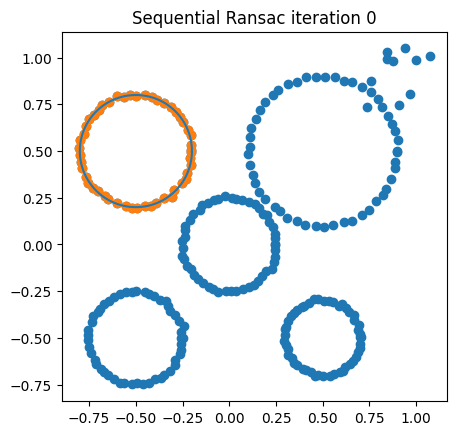

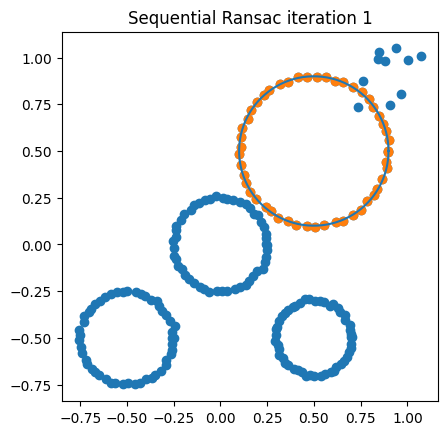

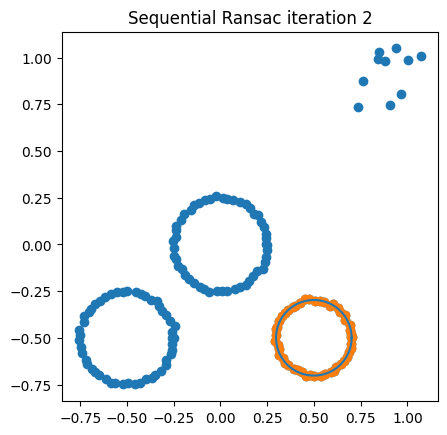

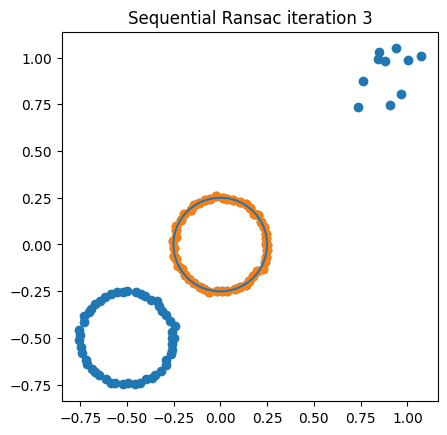

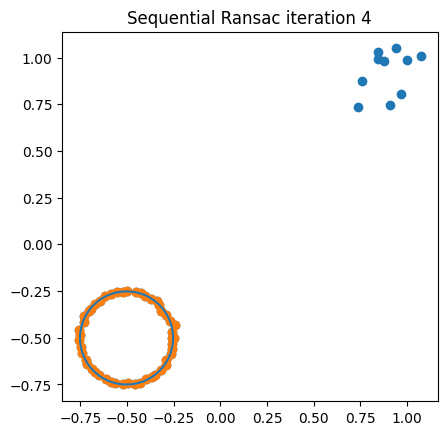

In [30]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):

    plt.gca().set_aspect('equal')
    th = np.linspace(0, 2 * np.pi, 100)
    x = currentModel[i][0] + currentModel[i][2] * np.cos(th)
    y = currentModel[i][1] + currentModel[i][2] * np.sin(th)

    # plotting Y, so the points that are not considered are removed at each iteration
    plt.plot(x,y)
    plt.scatter(Y[0, :], Y[1, :])
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]])

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y,currentInliers[i], axis=1)

    plt.title(f'Sequential Ransac iteration {i:d}')

    plt.show()